In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

### Read the processed data, retain the complete data, and adjust the time format

In [ ]:
df = pd.read_excel('MicroRV_CW.xlsx')
dfusd = pd.read_excel('micro_rv_usd.xlsx')
dfeuro = pd.read_excel('micro_rv_euro.xlsx')

def processdata(df):
    df.dropna(inplace=True) # dates where all benchmark instruments are available
    # convert date to format dd-mm-yyyy
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df.set_index('Date', inplace=True)
    # convert to float
    df = df.astype(np.float32)
    return df

df = processdata(df)
dfusd = processdata(dfusd)
dfeuro = processdata(dfeuro)

In [ ]:
def data_preprocess(df,type='gbp'):
    if type == 'gbp':
        columns = ['1W','2W']
        for i in [1,2,5,6,7,8,9,10,11]:
            columns.append(str(i)+'M')
        columns.append('1Y')
        columns.append('18M')
        for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
            columns.append(str(i)+'Y')
    
    elif type == 'euro':
        columns = ['1w','2w']
        for i in [1,2,3,4,5,6,7,8,9,10,11]:
            columns.append(str(i)+'M')
        columns.append('1Y')
        columns.append('18M')


        for i in [2,3,4,5,6,7,8,9,10,11,12,15,20,25,30,40,50]:
            columns.append(str(i)+'Y')
    
    else:
        columns = []
        for i in [1,2,3]:
            columns.append(str(i)+'W')
        for i in [1,2,3,4,5,6,7,8,9,10,11]:
            columns.append(str(i)+'M')
        columns.append('1Y')
        columns.append('18M')


        for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
            columns.append(str(i)+'Y')

    for old_name, new_name in zip(df.columns, columns):
        df.rename(columns={old_name: new_name}, inplace=True)
    
    return df

In [ ]:
# preprocess data
df = data_preprocess(df, 'gbp')
dfusd = data_preprocess(dfusd, 'usd')
dfeuro = data_preprocess(dfeuro, 'euro')

### Convert each term to the unit of years and construct a dictionary

In [ ]:
def transfer_dict_construct(df,type='gbp'):
    if type == 'gbp':
        tenors = np.array([1/52, 2/52, 1/12, 2/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50])
    elif type == 'usd':
        tenors = np.array([1/52,2/52,3/52,1/12,2/12,3/12,4/12,5/12,6/12, 7/12, 8/12, 9/12, 10/12,11/12, 12/12,  18/12,  2, 3, 4, 5, 6, 7, 8, 9, 10,12, 15, 20, 25, 30, 40, 50])
    else:
        tenors = np.array([1/52,2/52,1/12,2/12,3/12,4/12,5/12,6/12, 7/12, 8/12, 9/12, 10/12,11/12, 12/12, 18/12,  2, 3, 4, 5, 6, 7, 8, 9, 10,11,12, 15, 20, 25, 30, 40, 50])
    
    # a dictionary that match column names to tenors
    tenors_dict = dict(zip(df.columns, tenors))
    # fit a hermite spline to first row with selected tenors
    selected_tenors = df.columns # select some tenors not all to show that the curve is interpolated
    x = np.array([tenors_dict[i] for i in selected_tenors])
    date = df.index[0]
    y = df.loc[date, selected_tenors].values
    return x,y

In [ ]:
x,y = transfer_dict_construct(df, 'gbp')
xusd,yusd = transfer_dict_construct(dfusd, 'usd')
xeuro,yeuro = transfer_dict_construct(dfeuro, 'euro')

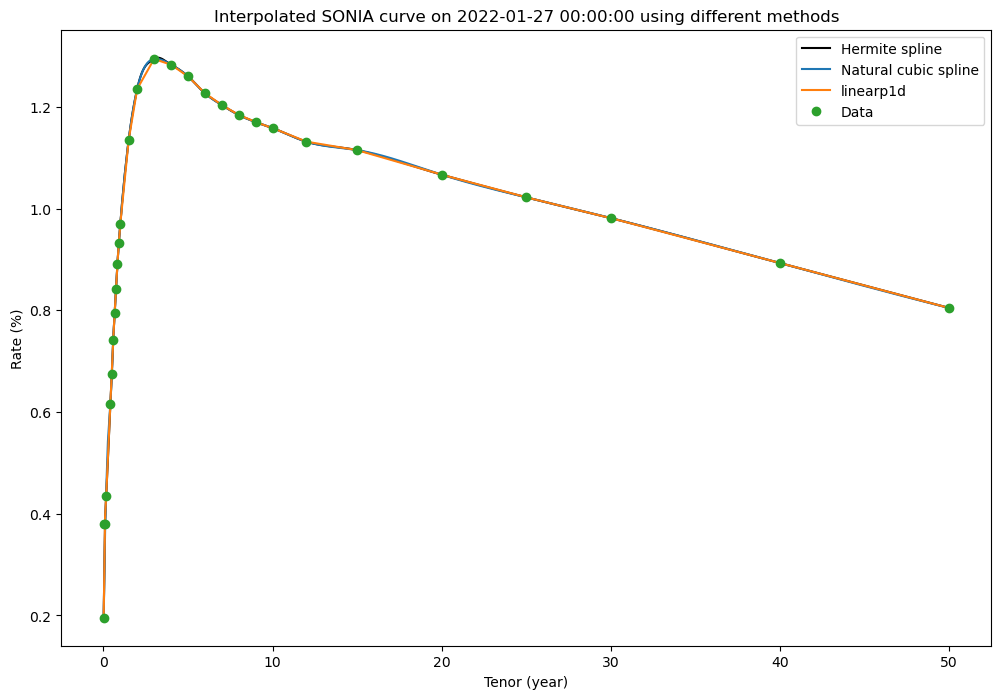

In [11]:
#gbp/usd
date = df.index[0]
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(1/52,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline',color='black')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date} using different methods')
plt.ylabel('Rate (%)')
plt.savefig("Example1.pdf",format = "pdf")

In [ ]:
#euro
date = df.index[0]
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(6/12,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date} using different methods')
plt.ylabel('Rate (%)')
plt.savefig("Example1.pdf",format = "pdf")

In [16]:
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

In [ ]:
def curvefit_demo(df,type='gbp'):
    if type == 'gbp':
        # Demonstrate fitting a curve using the first date
        valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
        spot_days = 0 # T+0 as shown in Bloomberg ticker
        settlement_date = valuation_date.add_weekdays(spot_days)
        cal = CalendarTypes.UNITED_KINGDOM
        # store SONIA swap as we only have swap as benchmark instruments
        swaps = []
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_365F # 365 fixed

    elif type == 'usd':
        # Demonstrate fitting a curve using the first date
        valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
        spot_days = 0 # T+0 as shown in Bloomberg ticker
        settlement_date = valuation_date.add_weekdays(spot_days)
        cal = CalendarTypes.UNITED_STATES
        # store SONIA swap as we only have swap as benchmark instruments
        swaps = []
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_360 
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_360 

    else:
        # Demonstrate fitting a curve using the first date
        valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
        spot_days = 0 # T+0 as shown in Bloomberg ticker
        settlement_date = valuation_date.add_weekdays(spot_days)
        cal = CalendarTypes.TARGET
        # store SONIA swap as we only have swap as benchmark instruments
        swaps = []
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_360 
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_360 

    for tenor in df.columns:
        if tenor[-1]=='Y': # only append yearly tenors for swap
            rate = df.loc[df.index[0], tenor]/100 # convert to %
            swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                            fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
            swaps.append(swap)

    curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES) 
    plotCurve(curve, valuation_date, 20, instr_mat_dates_or_tenor='1Y')
    plt.title(f'Interpolated SONIA curve on {df.index[0].strftime("%d-%m-%Y")}  for different rates')

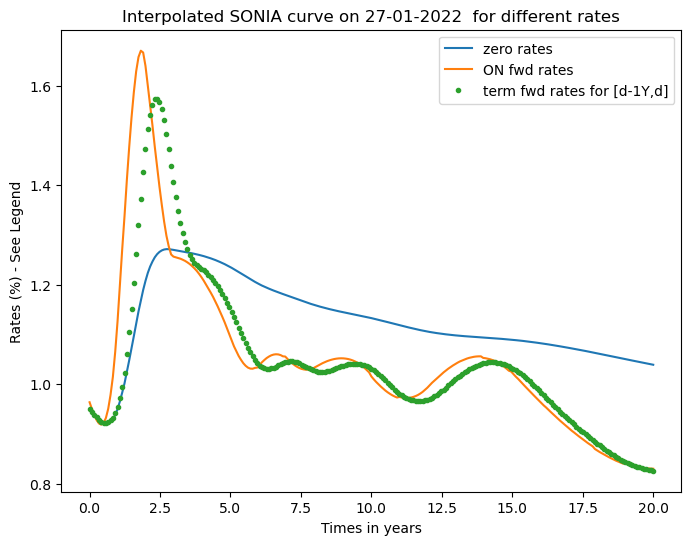

In [ ]:
#demonstrate curve on one date
curvefit_demo(df,type='gbp')

In [ ]:
def curvefit(df,type='gbp'):
    # create a yield curve dataset with columns in years, and rows same as df.index
    # create a curves dictionary to store the calibrated curve for each date
    curves = {}
    year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
    year_columns = [int(i[:-1]) for i in year_columns] # convert to int
    df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y

    if type == 'gbp':
        # swap characteristics
        cal = CalendarTypes.UNITED_KINGDOM
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_365F # 365 fixed
    
    elif type == 'usd':
        # swap characteristics
        cal = CalendarTypes.UNITED_STATES
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_360 
        fixedFreqType = FrequencyTypes.ANNUAL
        floatFreqType = FrequencyTypes.ANNUAL 
        floatDCCType = DayCountTypes.ACT_360 
    
    else:
        # swap characteristics
        cal = CalendarTypes.TARGET
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_360 
        fixedFreqType = FrequencyTypes.ANNUAL
        floatFreqType = FrequencyTypes.ANNUAL 
        floatDCCType = DayCountTypes.ACT_360 
        
    for date in tqdm(df.index, desc='Creating curves'):  # loop through each date in the dataset
        try:
            swaps = []
            day, month, year = date.day, date.month, date.year
            valuation_date = Date(day, month, year)  # convert to Date object
            spot_days = 0  # T+0
            settlement_date = valuation_date.add_weekdays(spot_days)
            for tenor in df.columns:  # loop through each tenor in the dataset
                if tenor[-1] == 'Y':
                    rate = df.loc[date, tenor]/100 
                    swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                                fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                                float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
                    swaps.append(swap)

            curve = IborSingleCurve(valuation_date, ibor_deposits=[], ibor_fras=[], ibor_swaps=swaps, interp_type=InterpTypes.NATCUBIC_ZERO_RATES)
            for year in year_columns:
                df_yield.loc[date, year] = curve.swap_rate(effective_dt=valuation_date, maturity_dt=valuation_date.add_years(year))
            curves[date] = curve  # add this curve to the dictionary
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

    return curves, df_yield

In [ ]:
curves, df_yield = curvefit(df,type='gbp')
curves_usd, df_yield_usd = curvefit(dfusd,type='usd')
curves_euro, df_yield_euro = curvefit(dfeuro,type='euro')

In [ ]:
# save curves to .pkl
with open('curves_gbp.pkl', 'wb') as f:
    pickle.dump(curves, f) # store the curves dictionary
df_yield.to_pickle('df_yield_gbp.pkl')

with open('curves_usd.pkl', 'wb') as f:
    pickle.dump(curves_usd, f) # store the curves dictionary
df_yield_usd.to_pickle('df_yield_usd.pkl')

with open('curves_euro.pkl', 'wb') as f:
    pickle.dump(curves_euro, f) # store the curves dictionary
df_yield_euro.to_pickle('df_yield_euro.pkl')

### butterfly

In [ ]:
# load curves (just a sample)
with open('curves.pkl', 'rb') as f:
    curves = pickle.load(f)  
df_yield = pd.read_pickle('df_yield.pkl')

In [ ]:
#calculate swap DV01
def swap_dv01(curve, start_date, maturity_date):
    """Estimate swap DV01 based on discounted cash flows """
    try:
        tau = 1  # annual accrual
        d = start_date.add_years(1)
        payment_dates = []
        while d <= maturity_date:
            payment_dates.append(d)
            d = d.add_years(1)
        discount_factors = [curve.df(p) for p in payment_dates]
        return sum(tau * df for df in discount_factors)
    except:
        return np.nan

In [ ]:
# define butterfly structure
def compute_fly_from_curves(curves, fly_legs, window=60, rate_type='forward',K=15):
    """
    Compute fly spread, z-score, and carry for given butterfly structures based on pre-fitted financepy curves.

    Parameters:
    - curves: dict[Date] → IborSingleCurve  
        A dictionary mapping dates to calibrated yield curves.
    - fly_legs: list of (a, b, c) tuples  
        Each tuple defines a butterfly structure with maturities (in years), representing (short, mid, long) tenors.
    - window: int  
        Rolling window size (in days) used for z-score and carry calculations.
    - rate_type: str, either 'zero' or 'forward'  
        Specifies which rate to extract from the curve for fly spread calculation.

    Returns:
    - fly_df: pd.DataFrame  
        Daily fly spreads for each structure.
    - zscore_df: pd.DataFrame  
        Daily z-scores of fly spreads based on rolling mean and standard deviation.
    - carry_df: pd.DataFrame  
        Estimated carry values for each structure, based on discounted cash flow approximation.
    """

    fly_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}
    zscore_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs} # z-score
    carry_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs} # carry
    dates = list(curves.keys()) #[0:21*K] # 252/12 = 21
    dates.sort()

    for idx in range(window, len(dates)):
        current_date = dates[idx]
        current_curve = curves[current_date]

        past_fly_dict = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}

        # Fly spread series over the past rolling window
        for hist_date in dates[idx - window: idx]:
            hist_curve = curves[hist_date]
            for (a, b, c) in fly_legs:
                d_a = Date(hist_date.day, hist_date.month, hist_date.year).add_years(a)
                d_b = Date(hist_date.day, hist_date.month, hist_date.year).add_years(b)
                d_c = Date(hist_date.day, hist_date.month, hist_date.year).add_years(c)

                if rate_type == 'zero':
                    try:
                        ra = hist_curve.zero_rate(d_a)
                        rb = hist_curve.zero_rate(d_b)
                        rc = hist_curve.zero_rate(d_c)
                    except:
                        continue
                elif rate_type == 'forward':
                    try:
                        ra = hist_curve.fwd(d_a)
                        rb = hist_curve.fwd(d_b)
                        rc = hist_curve.fwd(d_c)
                    except:
                        continue
                else:
                    raise ValueError("rate_type must be 'zero' or 'forward'")

                fly_hist = 2 * rb - ra - rc
                past_fly_dict[f"{a}-{b}-{c}"].append(fly_hist)

        # Fly spread, z-score, and carry on the current date
        for (a, b, c) in fly_legs:
            d_a = Date(current_date.day, current_date.month, current_date.year).add_years(a)
            d_b = Date(current_date.day, current_date.month, current_date.year).add_years(b)
            d_c = Date(current_date.day, current_date.month, current_date.year).add_years(c)

            try:
                if rate_type == 'zero':
                    ra = current_curve.zero_rate(d_a)
                    rb = current_curve.zero_rate(d_b)
                    rc = current_curve.zero_rate(d_c)
                else:
                    ra = current_curve.fwd(d_a)
                    rb = current_curve.fwd(d_b)
                    rc = current_curve.fwd(d_c)

                fly_today = 2 * rb - ra - rc
                fly_data[f"{a}-{b}-{c}"].append(fly_today)

                hist_vals = past_fly_dict[f"{a}-{b}-{c}"]
                if len(hist_vals) >= 5:
                    mu = np.mean(hist_vals)
                    sigma = np.std(hist_vals)
                    z = float((fly_today - mu) / sigma) if sigma > 1e-6 else 0
                else:
                    z = np.nan
                zscore_data[f"{a}-{b}-{c}"].append(z)

                # --------------------------
                # Compute carry (DV01-adjusted)
                # --------------------------
                # Define parameters
                notional_base = 1e6
                start_date = Date(current_date.day, current_date.month, current_date.year)

                # Compute DV01 for each leg
                def get_dv01(tenor):
                    maturity = start_date.add_years(tenor)
                    return swap_dv01(current_curve, start_date, maturity)

                dv01_a = get_dv01(a)
                dv01_b = get_dv01(b)
                dv01_c = get_dv01(c)
                direction_a = 1  # Side legs are payers; carry is signed as + (L − k)
                direction_b = -1   # The middle leg is a receiver; carry is signed as (k − L).
                direction_c = 1

                # Adjust the notional of the middle leg to achieve DV01 neutrality
                notional_a = notional_c = notional_base
                notional_b = (notional_a * dv01_a + notional_c * dv01_c) / (dv01_b)

                # Compute carry for each leg
                def compute_leg_carry(tenor, notional, direction):
                    maturity = start_date.add_years(tenor)
                    try:
                        L = current_curve.fwd(maturity)  # Floating rate
                        k = current_curve.swap_rate(start_date, maturity)  # fixed rate
                        tau = 1 if tenor >= 1 else tenor  
                        return notional * tau * (L - k) *direction
                    except:
                        return np.nan

                carry_a = compute_leg_carry(a, notional_a, direction_a)
                carry_b = compute_leg_carry(b, notional_b, direction_b)
                carry_c = compute_leg_carry(c, notional_c, direction_c)

                # Butterfly Carry 
                carry_today = float(carry_b + carry_a + carry_c)
                carry_data[f"{a}-{b}-{c}"].append(carry_today)

            except:
                fly_data[f"{a}-{b}-{c}"].append(np.nan)
                zscore_data[f"{a}-{b}-{c}"].append(np.nan)
                carry_data[f"{a}-{b}-{c}"].append(np.nan)

    fly_df = pd.DataFrame(fly_data, index=dates[window:])
    zscore_df = pd.DataFrame(zscore_data, index=dates[window:])
    carry_df = pd.DataFrame(carry_data, index=dates[window:])
    return fly_df, zscore_df,carry_df

In [ ]:
def calculate_z_carry(curves):
    fly_legs = [(2, 5, 10), (5, 10, 30), (3, 5, 7),(1, 4 ,7),(1, 3, 5),(10, 20, 30)]
    rollingwindows = [21,42,63,84,105,126]  #day, equivalent to 1, 2, 3, 4, 5, and 6 months; try different values of k
    fly_dfs = {}
    z_dfs = {}
    carry_dfs = {}

    for window in rollingwindows:
        fly_df, z_df, carry_df = compute_fly_from_curves(
            curves, 
            fly_legs, 
            window=window, 
            rate_type='forward', 
            K=15
        )
        
        # Store results using window size as the key
        fly_dfs[f"window_{window}"] = fly_df
        z_dfs[f"window_{window}"] = z_df
        carry_dfs[f"window_{window}"] = carry_df

    return fly_dfs,z_dfs,carry_dfs

In [ ]:
# calculate z-score and carry for differenct currencies (criteria)
fly_dfs_gbp ,z_dfs_gbp, carry_dfs_gbp = calculate_z_carry(curves)
fly_dfs_usd ,z_dfs_usd, carry_dfs_usd = calculate_z_carry(curves_usd)
fly_dfs_euro ,z_dfs_euro, carry_dfs_euro = calculate_z_carry(curves_euro)

In [ ]:
def select_best_trades(z_df, carry_df, n_z=100, carry_percent=0.8):
    """
    Strategy selection procedure:
    1. First, identify the trades whose carry ranks in the top `carry_percent` percentile of the entire dataset;
    2. Then, from these high-carry trades, select the top `n_z` trades with the largest absolute z-scores.

    Parameters:
    - z_df: pd.DataFrame  
        Each column represents a trade structure, with values being the corresponding z-scores.
    - carry_df: pd.DataFrame  
        Same structure as z_df, containing the carry values of each trade.
    - n_z: int  
        Number of trades to select with the highest absolute z-scores from the high-carry subset.
    - carry_percent: float  
        Percentile threshold to define high-carry trades (e.g., 0.8 means top 80%).

    Returns:
    - selected_trades: pd.DataFrame  
        Final selected trades with their z-scores and carry values.
    """

    # 1. Flatten to a Series for easier manipulation
    z_flat = z_df.stack().rename('z_score')
    carry_flat = carry_df.stack().rename('carry')

    # 2. Compute the carry quantile threshold (values above it fall into the top 80%)
    carry_threshold = carry_flat.quantile(1 - carry_percent)

    # 3. Select high-carry trades first
    high_carry_mask = carry_flat >= carry_threshold
    high_carry_z = z_flat[high_carry_mask]
    high_carry_carry = carry_flat[high_carry_mask]

    # 4. Select the top n_z trades with the largest absolute z-scores from the high-carry set
    top_z_index = high_carry_z.abs().nlargest(n_z).index

    # 5. Combine and return the result
    selected = pd.concat([high_carry_z.loc[top_z_index], high_carry_carry.loc[top_z_index]], axis=1)
    selected.columns = ['z_score', 'carry']
    return selected.sort_values(by='z_score', ascending=False)

In [40]:
def select_best_trades_all(z_dfs, carry_dfs):
    best_trades_dfs = {}
    N_ALL = [10,15,20,25,30,35,40,45,50,60,70,80,90,100,120,150,180,200]
    rollingwindows = [21,42,63,84,105,126]

    total_iterations = len(N_ALL) * len(rollingwindows)
    with tqdm(total=total_iterations, desc="Selecting Best Trades") as pbar:
        for N in N_ALL:
            for window in rollingwindows:
                z_df = z_dfs[f"window_{window}"]
                carry_df = carry_dfs[f"window_{window}"]
                best_trades = select_best_trades(z_df, carry_df, n_z=N, carry_percent=0.8)
                best_trades_dfs[f"window_{window}_N_{N}"] = best_trades
                pbar.set_postfix(window=window, N=N, count=len(best_trades))
                pbar.update(1)

    return best_trades_dfs

In [ ]:
# select best trades based on z-score and carry
best_trades_dfs_gbp = select_best_trades_all(z_dfs_gbp, carry_dfs_gbp)
best_trades_dfs_usd = select_best_trades_all(z_dfs_usd, carry_dfs_usd)
best_trades_dfs_euro = select_best_trades_all(z_dfs_euro, carry_dfs_euro)

In [ ]:
def simulate_fly_pnl_dv01(start_date, structure, curves, notional=1e6,direction=1):
    """
    Simulate the PnL of a fly spread strategy based on swap DV01 approximation.

    Parameters:
    - start_date: pd.Timestamp  
        The trade entry date when the signal is triggered (position opening).
    - structure: tuple (a, b, c)  
        Defines the fly structure as 2b - a - c, where a, b, c are maturities (in years).
    - curves: dict[pd.Timestamp] → IborSingleCurve  
        A dictionary mapping each date to a calibrated interest rate curve.
    - notional: float  
        Notional amount for each leg of the swap; default is 1,000,000.

    Returns:
    - pnl_series: pd.Series  
        Time series of the cumulative PnL of the fly structure.
    - leg_pnls: pd.DataFrame  
        Time series of individual leg PnLs within the fly structure.
    """
    
    a, b, c = structure
    all_dates = sorted([d for d in curves if d >= start_date])
    if len(all_dates) == 0:
        return None, None

    # Start date & maturity of each leg
    d0 = start_date
    d0_date = Date(d0.day, d0.month, d0.year)
    mty_a = d0_date.add_years(a)
    mty_b = d0_date.add_years(b)
    mty_c = d0_date.add_years(c)

    curve_0 = curves[d0]

    # Swap rate and DV01 for each leg at entry
    legs = {
        'a': {'mty': mty_a, 'sign': -1},
        'b1': {'mty': mty_b, 'sign': 1},
        'c': {'mty': mty_c, 'sign': -1},
    }

    for key, leg in legs.items():
        leg['rate_open'] = curve_0.swap_rate(d0_date, leg['mty'])
        leg['dv01'] = swap_dv01(curve_0, d0_date, leg['mty'])

    legs['a']['notional'] = notional
    legs['c']['notional'] = notional
    legs['b1']['notional'] = (notional * legs['a']['dv01'] + notional * legs['c']['dv01']) / (legs['b1']['dv01'])
    #print(legs['b1']['notional'])

    # Simulate daily PnL during the holding period
    pnl_data = {k: [] for k in legs}
    total_pnl = []

    for d in all_dates:
        curve = curves[d]
        d_date = Date(d.day, d.month, d.year)
        daily_pnl = 0
        for key, leg in legs.items():
            try:
                rate_now = curve.swap_rate(d_date, leg['mty']) # Important: Maturity dates are fixed from entry date — do not shift with current date
                rate_diff = rate_now - leg['rate_open']
                if direction == 1 :
                    leg_pnl = float(rate_diff * leg['dv01'] * leg['notional'] * leg['sign'])
                    pnl_data[key].append(leg_pnl)
                    daily_pnl += leg_pnl
            except:
                pnl_data[key].append(np.nan)
                daily_pnl = np.nan
        total_pnl.append(daily_pnl)

    pnl_series = pd.Series(total_pnl, index=all_dates)
    leg_pnls = pd.DataFrame(pnl_data, index=all_dates)
    return pnl_series, leg_pnls

In [ ]:
def calculate_top_n_fly_trades_dv01(top_signals, curves, notional=1e6):
    """
    Accurately compute the PnL of each trade using DV01-based approximation.

    Parameters:
    - top_signals: pd.DataFrame  
        The selected top trades (e.g., from z-score and carry filtering), each with a trade date and structure.
    - curves: dict[pd.Timestamp] → IborSingleCurve  
        A dictionary mapping each date to its corresponding calibrated interest rate curve.
    - notional: float  
        Notional amount used for each swap leg in the DV01-based PnL calculation.

    Returns:
    - result_df: pd.DataFrame  
        Detailed PnL records for each trade, including per-leg and cumulative PnL.
    - summary: dict or pd.DataFrame  
        Summary statistics such as average PnL, hit ratio, Sharpe ratio, etc.
    """
    records = []

    for (date, structure_str) in top_signals.index:
        z_score,carry = top_signals.loc[date, structure_str]
        structure = tuple(map(int, structure_str.split('-')))
        direction = -1 if z_score > 0 else 1  # A positive z-score implies a short fly position, while a negative z-score implies a long fly position.

        try:
            pnl_series, leg_pnls = simulate_fly_pnl_dv01(date, structure, curves, notional=notional)
            if pnl_series is None or pnl_series.dropna().empty:
                continue

            adjusted_pnl = direction * pnl_series
            final_pnl = adjusted_pnl.dropna().iloc[-1] # PnL at maturity or on the last day
            max_drawdown = (adjusted_pnl.cummax() - adjusted_pnl).max()

            records.append({
                'start_date': date,
                'structure': structure_str,
                'z_score': z_score,
                'carry':carry,
                'direction': 'short fly' if z_score > 0 else 'long fly',
                'final_pnl': final_pnl,
                'max_drawdown': max_drawdown,
                'duration': len(adjusted_pnl)
            })
        except Exception as e:
            continue

    result_df = pd.DataFrame(records)
    
    summary = {
        'Total Trades': len(result_df),
        'Win Ratio': (result_df['final_pnl'] > 0).mean(),
        'Average PnL': result_df['final_pnl'].mean(),
        'Average Max Drawdown': result_df['max_drawdown'].mean(),
        'Average Duration': result_df['duration'].mean()
    }
    
    return result_df, summary

In [ ]:
def calculate_pnl(best_trades_dfs, curves):
    results = {}
    summaries = {}
    rollingwindows = [21, 42, 63, 84, 105, 126]
    N_ALL = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200]

    total_tasks = len(rollingwindows) * len(N_ALL)
    with tqdm(total=total_tasks, desc="Running Backtests") as pbar:
        for N in N_ALL:
            for window in rollingwindows:
                key = f"window_{window}_N_{N}"
                best_trades = best_trades_dfs[key]
                result, summary = calculate_top_n_fly_trades_dv01(best_trades, curves, notional=1e6)
                results[key] = result
                summaries[key] = summary
                pbar.set_postfix(window=window, N=N)
                pbar.update(1)

    return results, summaries

In [ ]:
results_gbp,summaries_gbp = calculate_pnl(best_trades_dfs_gbp,curves)
results_usd,summaries_usd = calculate_pnl(best_trades_dfs_usd,curves_usd)
results_euro,summaries_euro = calculate_pnl(best_trades_dfs_euro,curves_euro)

In [ ]:
# save results and summaries
with open("results_gbp.pkl", "wb") as f:
    pickle.dump(results_gbp, f)

with open("results_usd.pkl", "wb") as f:
    pickle.dump(results_usd, f)

with open("results_euro.pkl", "wb") as f:
    pickle.dump(results_euro, f)

with open("summaries_gbp.pkl", "wb") as f:
    pickle.dump(summaries_gbp, f)

with open("summaries_usd.pkl", "wb") as f:
    pickle.dump(summaries_usd, f)

with open("summaries_euro.pkl", "wb") as f:
    pickle.dump(summaries_euro, f)

In [102]:
plt.style.use('ggplot')

# Assume we have the data frames from the previous code
# fly_df_forward: DataFrame of butterfly spreads
# z_df_forward: DataFrame of z-scores
# best_10_trades: Series of the top 10 trades by absolute z-score
# result: DataFrame with backtest results for top trades

# 1. Z-Score Evolution Over Time
def plot_zscore_evolution(z_df, windowuse, Nuse, currency, best_trades=None):
    """Plot z-scores over time with highlights for filtered trades"""
    plt.figure(figsize=(14, 8))
    
    # Plot all z-scores as light lines
    for col in z_df.columns:
        plt.plot(z_df.index, z_df[col], alpha=0.3, linewidth=1, color='gray')

    legend_handles = []
    legend_labels = []
    
    # Highlight filtered trades
    if best_trades is not None and not best_trades.empty:
        structures_to_highlight = best_trades.index.get_level_values(1).unique()
        
        for structure in structures_to_highlight:
            if structure in z_df.columns:
                line, = plt.plot(z_df.index, z_df[structure], 
                               linewidth=2, 
                               label=f'_nolegend_')  
                if structure not in legend_labels:
                    legend_handles.append(line)
                    legend_labels.append(structure)
        
        scatter = None
        for (date, structure), _ in best_trades.iterrows():
            if structure in z_df.columns:
                scatter = plt.scatter(date, z_df.loc[date, structure],
                                    s=100, color='red', zorder=5,
                                    edgecolor='black', 
                                    label='Selected Trades' if not scatter else None)
        
        if scatter is not None and 'Selected Trades' not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append('Selected Trades')
    
    line_z2 = plt.axhline(y=2, color='red', linestyle='--', alpha=0.7)
    line_z_neg2 = plt.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
    line_zero = plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    legend_handles.extend([line_z2, line_z_neg2, line_zero])
    legend_labels.extend(['Z = +2', 'Z = -2', 'Zero Line'])
    
    plt.legend(legend_handles, legend_labels, 
             loc='upper right', 
             bbox_to_anchor=(1.15, 1),
             frameon=True)
    
    plt.title(f"Z-Score Evolution Over Time ({currency}, Window={windowuse // 21} months, N={Nuse})", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Z-Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 2. carry Evolution Over Time
def plot_carry_evolution(carry_df, windowuse, Nuse,currency, best_trades=None):
    """Plot carry values over time with highlights for filtered trades"""
    plt.figure(figsize=(14, 8))
    
    # Plot all carry values as light lines
    for col in carry_df.columns:
        plt.plot(carry_df.index, carry_df[col], alpha=0.3, linewidth=1, color='gray')

    legend_handles = []
    legend_labels = []
    
    # Highlight filtered trades
    if best_trades is not None and not best_trades.empty:
        structures_to_highlight = best_trades.index.get_level_values(1).unique()
        
        for structure in structures_to_highlight:
            if structure in carry_df.columns:
                line, = plt.plot(carry_df.index, carry_df[structure], 
                               linewidth=2, 
                               label=f'_nolegend_')  
                if structure not in legend_labels:
                    legend_handles.append(line)
                    legend_labels.append(structure)
        
        scatter = None
        for (date, structure), _ in best_trades.iterrows():
            if structure in carry_df.columns:
                scatter = plt.scatter(date, carry_df.loc[date, structure],
                                    s=100, color='blue', zorder=5,
                                    edgecolor='black', 
                                    label='Selected Trades' if not scatter else None)
        
        if scatter is not None and 'Selected Trades' not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append('Selected Trades')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.legend(legend_handles, legend_labels, 
             loc='upper right', 
             bbox_to_anchor=(1.15, 1),
             frameon=True)
    
    plt.title(f"Carry Evolution Over Time ({currency}, Window={windowuse // 21} months, N={Nuse})", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Carry Value', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 3. Butterfly Spread Evolution
def plot_fly_evolution(fly_df, windowuse, Nuse,currency):
    """Plot butterfly spreads over time"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for col in fly_df.columns:
        ax.plot(fly_df.index, fly_df[col] * 10000, label=col)  # Convert to basis points
    
    ax.set_title(f"Butterfly Spread Evolution ({currency}, Window={windowuse // 21} months, N={Nuse})", fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Spread (bps)', fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True)  # Legend outside
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# 4. PnL Evolution for Top Trades
def plot_pnl_evolution(curves, best_trades, windowuse, Nuse,currency, notional=1e6):
    """Plot PnL evolution for dynamic number of trades"""
    plt.figure(figsize=(14, 8))
    
    n_trades = len(best_trades)
    colors = plt.cm.viridis(np.linspace(0, 1, n_trades))
    
    # Check input types
    if isinstance(best_trades, pd.DataFrame):
        # Handle a DataFrame with multiple columns
        iterator = best_trades['z_score'].items()
    else:
        # Handle a Series
        iterator = best_trades.items()

    for i, ((start_date, structure_str), z_score) in enumerate(iterator):
        # Dynamically handle different structures
        structure = tuple(map(int, structure_str.split('-')))
        direction = -1 if z_score > 0 else 1
        
        # Simulate PnL
        pnl_series, _ = simulate_fly_pnl_dv01(start_date, structure, curves, notional)
        if pnl_series is not None and not pnl_series.empty:
            adjusted_pnl = direction * pnl_series #.cumsum()
            plt.plot(adjusted_pnl.index, adjusted_pnl.values,
                     label=f"{structure_str} ({start_date.strftime('%Y-%m')})",
                     color=colors[i], linewidth=1.5, alpha=0.8)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.title(f'PnL Evolution for Top Trades ({currency}, Window={windowuse // 21} months, N={Nuse})', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('PnL ($)', fontsize=14)
    #plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

def save_signal_evolution_plots(z_df, carry_df, fly_df, best_trades, curves,windowuse,Nuse,currency,output_dir="charts/evolution"):
    os.makedirs(output_dir, exist_ok=True)

    fig1 = plot_zscore_evolution(z_df, windowuse,Nuse,currency, best_trades)
    fig1.savefig(os.path.join(output_dir, f"zscore_evolution_currency_{currency}_window{windowuse}_N{Nuse}.pdf"), format="pdf", bbox_inches="tight")
    plt.close(fig1)

    fig2 = plot_carry_evolution(carry_df,windowuse,Nuse,currency, best_trades)
    fig2.savefig(os.path.join(output_dir, f"carry_evolution_currency_{currency}_window{windowuse}_N{Nuse}.pdf"), format="pdf", bbox_inches="tight")
    plt.close(fig2)

    fig3 = plot_fly_evolution(fly_df,windowuse,Nuse,currency)
    fig3.savefig(os.path.join(output_dir, f"fly_evolution_currency_{currency}_window{windowuse}_N{Nuse}.pdf"), format="pdf", bbox_inches="tight")
    plt.close(fig3)

    fig4 = plot_pnl_evolution(curves, best_trades,windowuse,Nuse,currency)
    fig4.savefig(os.path.join(output_dir, f"pnl_evolution_currency_{currency}_window{windowuse}_N{Nuse}.pdf"), format="pdf", bbox_inches="tight")
    plt.close(fig4)

# 5. Trade Performance Summary
def plot_summary_table(result, save_path, windowuse, Nuse, currency, figsize=(6, 5)):
    """Draw a standalone trade performance summary table"""
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')

    # Calculate summary metrics
    win_rate = (result['final_pnl'] > 0).mean() * 100
    avg_win = result[result['final_pnl'] > 0]['final_pnl'].mean() if any(result['final_pnl'] > 0) else 0
    avg_loss = result[result['final_pnl'] < 0]['final_pnl'].mean() if any(result['final_pnl'] < 0) else 0
    profit_factor = abs(result[result['final_pnl'] > 0]['final_pnl'].sum() / 
                        result[result['final_pnl'] < 0]['final_pnl'].sum()) if result[result['final_pnl'] < 0]['final_pnl'].sum() != 0 else float('inf')

    summary_data = [
        ["Number of Trades", len(result)],
        ["Win Rate", f"{win_rate:.2f}%"],
        ["Average PnL", f"${result['final_pnl'].mean():.2f}"],
        ["Average Win", f"${avg_win:.2f}"],
        ["Average Loss", f"${avg_loss:.2f}"],
        ["Profit Factor", f"{profit_factor:.2f}"],
        ["Max PnL", f"${result['final_pnl'].max():.2f}"],
        ["Min PnL", f"${result['final_pnl'].min():.2f}"],
        ["Average Max Drawdown", f"${result['max_drawdown'].mean():.2f}"],
        ["Average Duration", f"{result['duration'].mean():.1f} days"]
    ]

    table = ax.table(cellText=summary_data, colLabels=["Metric", "Value"], 
                     cellLoc='center', loc='center', cellColours=[['#f2f2f2']*2]*len(summary_data))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    plt.suptitle(f"Trade Performance Summary ({currency}, Window={windowuse // 21} months, N={Nuse})", fontsize=16)
    plt.tight_layout()

    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.close(fig)

    return fig

# bar plot N
def plot_avg_pnl_by_N(summaries, target_window, currency):
    """ Plot a bar chart of average PnL for different N values under a specified rolling window """
    # Extract data and filter by specified window size
    data = []
    for key in summaries:
        parts = key.split('_')
        current_window = parts[1]  
        N = parts[-1]
        
        if int(current_window) == target_window:
            avg_pnl = summaries[key].get("Average PnL", 0)
            data.append({
                "N": int(N),
                "Avg PnL": avg_pnl
            })
    
    if not data:
        raise ValueError(f"No data found for window={target_window}")
    
    df = pd.DataFrame(data).sort_values('N')  # sort by N
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(
        x=df['N'].astype(str),  
        height=df['Avg PnL'],
        color='orange',
        edgecolor='black',
        alpha = 0.5
    )

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.0f}',
            ha='center',
            va='bottom',
            color = 'black'
        )

    ax.set_title(f"Average PnL by N ({currency}, Window={target_window // 21} months)", fontsize=14)
    ax.set_xlabel("N Value", fontsize=12)
    ax.set_ylabel("Average PnL", fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# bar plot winodw
def plot_avg_pnl_by_window(summaries, target_N, currency):
    """Plot a bar chart of average PnL for different rolling windows under a specified N """
    # Extract data and filter by specified window size
    data = []
    for key in summaries:
        parts = key.split('_')
        current_window = parts[1] 
        N = parts[-1]
        
        if int(N) == target_N:  
            avg_pnl = summaries[key].get("Average PnL", 0)
            data.append({
                "window": int(current_window) // 21 ,
                "Avg PnL": avg_pnl
            })
    
    if not data:
        raise ValueError(f"No data found for window={target_N}")
    
    df = pd.DataFrame(data).sort_values('window')  # sort by window
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(
        x=df['window'].astype(str),  
        height=df['Avg PnL'],
        color='green',
        edgecolor='black',
        alpha = 0.5
    )
 
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.0f}',
            ha='center',
            va='bottom',
            color = 'black'
        )

    ax.set_title(f"Average PnL by Window ({currency}, N={target_N})", fontsize=14)
    ax.set_xlabel("Window Value (Months)", fontsize=12)
    ax.set_ylabel("Average PnL", fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

def save_pnl_summary_charts(summaries, target_windows, target_Ns, currency, output_dir="charts/summary"):
    os.makedirs(output_dir, exist_ok=True)

    for w in target_windows:
        fig_n = plot_avg_pnl_by_N(summaries, w, currency)
        fig_n.savefig(os.path.join(output_dir, f"avg_pnl_by_N_currency_{currency}_window{w}.pdf"), format="pdf", bbox_inches="tight")
        plt.close(fig_n)

    for n in target_Ns:
        fig_w = plot_avg_pnl_by_window(summaries, n, currency)
        fig_w.savefig(os.path.join(output_dir, f"avg_pnl_by_window_currency_{currency}_N{n}.pdf"), format="pdf", bbox_inches="tight")
        plt.close(fig_w)
    
    
def plot_pnl_distribution(result, save_path, windowuse, Nuse, currency, figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(result['final_pnl'], bins=10, kde=True, ax=ax)
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Distribution of Final PnL ({currency}, Window={windowuse // 21} months, N={Nuse})')
    ax.set_xlabel('PnL ($)')
    ax.set_ylabel('Frequency')
    fig.tight_layout()
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.close(fig)

def plot_avg_pnl_by_structure(result, save_path, windowuse, Nuse, currency, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    avg_pnl_by_structure = result.groupby('structure')['final_pnl'].mean().sort_values()
    sns.barplot(x=avg_pnl_by_structure.index, y=avg_pnl_by_structure.values, ax=ax)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'Average PnL by Structure ({currency}, Window={windowuse // 21} months, N={Nuse})')
    ax.set_ylabel('Average PnL ($)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig.tight_layout()
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.close(fig)

def plot_pnl_vs_zscore(result, save_path, windowuse, Nuse, currency, figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x='z_score', y='final_pnl', data=result, s=70, hue='structure', ax=ax)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'Final PnL vs Z-Score ({currency}, Window={windowuse // 21} months, N={Nuse})')
    ax.set_xlabel('Z-Score at Entry')
    ax.set_ylabel('Final PnL ($)')
    fig.tight_layout()
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.close(fig)

def plot_pnl_vs_carry(result, save_path, windowuse, Nuse, currency, figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x='carry', y='final_pnl', data=result, s=70, hue='structure', ax=ax)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'Final PnL vs Carry ({currency}, Window={windowuse // 21} months, N={Nuse})')
    ax.set_xlabel('Carry at Entry')
    ax.set_ylabel('Final PnL ($)')
    fig.tight_layout()
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.close(fig)

def plot_pnl_vs_duration(result, save_path, windowuse, Nuse, currency, figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x='duration', y='final_pnl', data=result, s=70, ax=ax)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'Final PnL vs Duration ({currency}, Window={windowuse // 21} months, N={Nuse})')
    ax.set_xlabel('Duration (days)')
    ax.set_ylabel('Final PnL ($)')
    fig.tight_layout()
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.close(fig)

def plot_zscore_box(result, save_path, windowuse, Nuse, currency, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(x='structure', y='z_score', data=result, ax=ax)
    ax.set_title(f'Z-Score Distribution by Structure ({currency}, Window={windowuse // 21} months, N={Nuse})')
    ax.set_ylabel('Z-Score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig.tight_layout()
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.close(fig)

def plot_carry_box(result, save_path, windowuse, Nuse, currency, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(x='structure', y='carry', data=result, ax=ax)
    ax.set_title(f'Carry Distribution by Structure ({currency}, Window={windowuse // 21} months, N={Nuse})')
    ax.set_ylabel('Carry')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig.tight_layout()
    fig.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.close(fig)

def save_all_trade_charts(result, windowuse, Nuse, currency, output_dir="charts"):
    os.makedirs(output_dir, exist_ok=True)
    plot_pnl_distribution(result, os.path.join(output_dir, f"pnl_distribution_currency_{currency}_window{windowuse}_N{Nuse}.pdf"),windowuse, Nuse, currency)
    plot_avg_pnl_by_structure(result, os.path.join(output_dir, f"avg_pnl_by_structure_currency_{currency}_window{windowuse}_N{Nuse}.pdf"),windowuse, Nuse, currency)
    plot_pnl_vs_zscore(result, os.path.join(output_dir, f"pnl_vs_zscore_currency_{currency}_window{windowuse}_N{Nuse}.pdf"),windowuse, Nuse, currency)
    plot_pnl_vs_carry(result, os.path.join(output_dir, f"pnl_vs_carry_currency_{currency}_window{windowuse}_N{Nuse}.pdf"),windowuse, Nuse, currency)
    plot_pnl_vs_duration(result, os.path.join(output_dir, f"pnl_vs_duration_currency_{currency}_window{windowuse}_N{Nuse}.pdf"),windowuse, Nuse, currency)
    plot_zscore_box(result, os.path.join(output_dir, f"zscore_boxplot_currency_{currency}_window{windowuse}_N{Nuse}.pdf"),windowuse, Nuse, currency)
    plot_carry_box(result, os.path.join(output_dir, f"carry_boxplot_currency_{currency}_window{windowuse}_N{Nuse}.pdf"),windowuse, Nuse, currency)
    plot_summary_table(result, os.path.join(output_dir, f"trade_summary_table_currency_{currency}_window{windowuse}_N{Nuse}.pdf"),windowuse, Nuse, currency)


In [101]:
def draw_and_save_charts(windowuse, Nuse, currency, z_dfs, carry_dfs, fly_dfs, results, best_trades_dfs,curves,summeries):
    rollingwindows = [21, 42, 63, 84, 105, 126]
    N_ALL = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200]
    z_df = z_dfs[f"window_{windowuse}"]
    carry_df = carry_dfs[f"window_{windowuse}"]
    fly_df = fly_dfs[f"window_{windowuse}"]
    result = results[f"window_{windowuse}_N_{Nuse}"]
    best_trades = best_trades_dfs[f"window_{windowuse}_N_{Nuse}"]

    save_signal_evolution_plots(z_df,carry_df,fly_df,best_trades,curves,windowuse,Nuse,currency)
    save_pnl_summary_charts(summeries, rollingwindows, N_ALL, currency)
    save_all_trade_charts(result,windowuse,Nuse, currency)

In [103]:
windowuse = 84
Nuse = 20
rollingwindows = [21, 42, 63, 84, 105, 126]
N_ALL = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200]

currency = 'GBP'
draw_and_save_charts(windowuse, Nuse, currency, z_dfs_gbp, carry_dfs_gbp, fly_dfs_gbp, results_gbp, best_trades_dfs_gbp,curves,summaries_gbp)

In [104]:
currency = 'USD'
draw_and_save_charts(windowuse, Nuse, currency, z_dfs_usd, carry_dfs_usd, fly_dfs_usd, results_usd, best_trades_dfs_usd,curves_usd,summaries_usd)

In [105]:
currency = 'EURO'
draw_and_save_charts(windowuse, Nuse, currency, z_dfs_euro, carry_dfs_euro, fly_dfs_euro, results_euro, best_trades_dfs_euro,curves_euro,summaries_euro)